In [1]:
!pip install opencv-python scikit-image matplotlib ultralytics ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

This is a test notebook that intends to show how compression might affect object detection.

## Downloading Dataset

I will test using the [VIRAT Video Dataset](https://data.kitware.com/#collection/56f56db28d777f753209ba9f/folder/56f570368d777f753209baab). This dataset contains surveillance-style videos with people, vehicles and activities. It also has annotations of bounding boxes and activities.

In [2]:
import os
import zipfile
import urllib.request

In [4]:
url = "https://data.kitware.com/api/v1/item/56f5851c8d777f753209ca59/download?contentDisposition=inline"
output_path = 'video.mp4'
extract_directory = './dataset'

In [5]:
urllib.request.urlretrieve(url, output_path)
print("Download complete.")

Download complete.


In [10]:
ORIGINAL_VIDEO = f"/content/{output_path}"

## Compression

In [11]:
import ffmpeg

In [12]:
def compress_video(input_path, output_path, codec, crf=23):
  ffmpeg.input(input_path).output(output_path, vcodec=codec, crf=crf).run()

In [13]:
compressed_h264 = "compressed_h264.mp4"
compress_video(ORIGINAL_VIDEO, compressed_h264, codec="libx264", crf=23)

## Frame Extraction

In [14]:
import cv2
import matplotlib.pyplot as plt

In [15]:
def extract_frames(video_path, out_dir):
  os.makedirs(out_dir, exist_ok=True)
  cap = cv2.VideoCapture(video_path)
  frame_idx = 0;
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break
    cv2.imwrite(f"{out_dir}/frame_{frame_idx:04d}.png", frame)
    if frame_idx == 0: #display the first frame
      plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) #convert from BGR to RGB
      plt.show()
    frame_idx += 1
  cap.release()

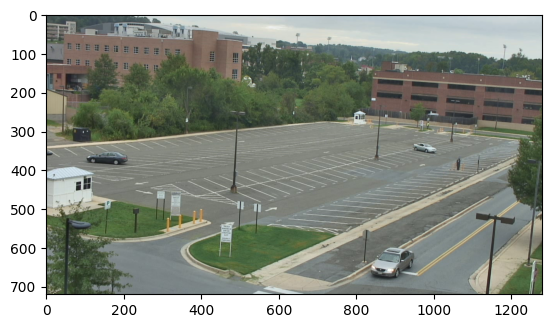

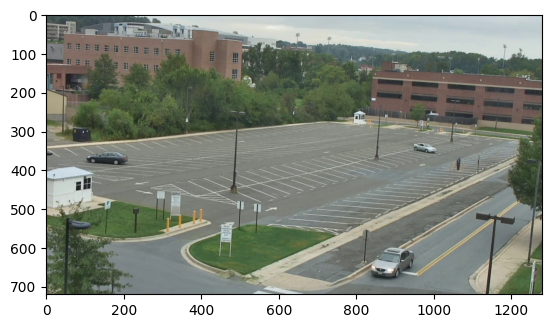

In [16]:
extract_frames(ORIGINAL_VIDEO, "frames/original")
extract_frames(compressed_h264, "frames/h264")

## Object Detection

In [17]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [18]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 160MB/s]


In [19]:
def run_detection(image_path):
  result = model(image_path)
  return result[0].boxes.xyxy.cpu().numpy()

In [20]:
boxes = run_detection("frames/original/frame_0000.png") # Test on one frame


image 1/1 /content/frames/original/frame_0000.png: 384x640 3 cars, 1 truck, 317.6ms
Speed: 10.4ms preprocess, 317.6ms inference, 33.5ms postprocess per image at shape (1, 3, 384, 640)


## Artifact Visualization

In [21]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [22]:
def compute_ssim(img1_path, img2_path):
  img1 = cv2.imread(img1_path)
  img2 = cv2.imread(img2_path)
  score, diff = ssim(img1, img2, full=True, channel_axis=2)
  diff = (diff * 255).astype("uint8")
  return score, diff

In [23]:
def draw_boxes(img_path, boxes):
  img = cv2.imread(img_path)
  for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  return img[..., ::-1] # BGR to RGB

In [24]:
original_img = draw_boxes("frames/original/frame_0000.png", run_detection("frames/original/frame_0000.png"))
h264_img = draw_boxes("frames/h264/frame_0000.png", run_detection("frames/h264/frame_0000.png"))
ssim_score, diff = compute_ssim("frames/original/frame_0000.png", "frames/h264/frame_0000.png")


image 1/1 /content/frames/original/frame_0000.png: 384x640 3 cars, 1 truck, 151.9ms
Speed: 2.2ms preprocess, 151.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/frames/h264/frame_0000.png: 384x640 4 cars, 144.5ms
Speed: 2.2ms preprocess, 144.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


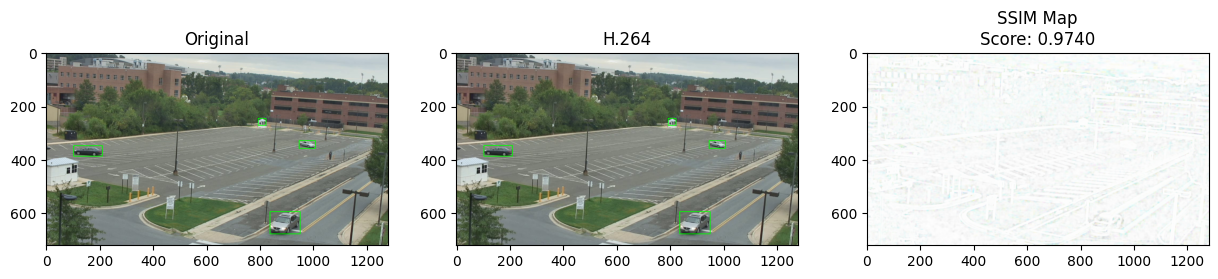

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(original_img); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(h264_img); plt.title("H.264")
plt.subplot(1,3,3); plt.imshow(diff, cmap='gray'); plt.title(f"SSIM Map\nScore: {ssim_score:.4f}")
plt.show()